# Relax Take-Home Challenge

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Reading in tables and creating dfs
users = pd.read_csv('takehome_users.csv',encoding='latin-1')
engagement = pd.read_csv('takehome_user_engagement.csv',encoding='latin-1')

In [9]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [67]:
users.info()
# There are some null values in the last_sesstion_creation_time and invited_by_user_id

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   creation_source             12000 non-null  object 
 3   last_session_creation_time  12000 non-null  float64
 4   opted_in_to_mailing_list    12000 non-null  int64  
 5   enabled_for_marketing_drip  12000 non-null  int64  
 6   org_id                      12000 non-null  int64  
 7   invited_by_user_id          6417 non-null   float64
 8   adopted                     12000 non-null  int32  
dtypes: float64(2), int32(1), int64(4), object(2)
memory usage: 797.0+ KB


In [10]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [16]:
engagement.info()
# There doesn't appear to be any missing values here

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


### Data Cleaning

In [53]:
# Dropping name and email columns since those won't help to solve this problem
users = users.drop(['name', 'email'], axis=1)

In [57]:
# Filling nan values for last creation time with zeros
users.last_session_creation_time = users.last_session_creation_time.fillna(0)

In [68]:
# Convert creation_time and last_session_creation_time to datetime objects
users.creation_time = pd.to_datetime(users.creation_time)
users.last_session_creation_time = pd.to_datetime(users.last_session_creation_time,unit='s')

In [18]:
# Converting time_stamp to a datetime object
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])

In [19]:
engagement['yr_wk'] = engagement['time_stamp'].dt.strftime('%Y-%U')

In [20]:
engagement.head()

,time_stamp,user_id,visited,yr_wk
0,2014-04-22 03:53:30,1,1,2014-16
1,2013-11-15 03:45:04,2,1,2013-45
2,2013-11-29 03:45:04,2,1,2013-47
3,2013-12-09 03:45:04,2,1,2013-49
4,2013-12-25 03:45:04,2,1,2013-51


In [36]:
# Creating usage dataframe with number of logins by user in a week
usage = engagement.groupby(['user_id', 'yr_wk']).size().reset_index().rename(columns={0:'count'})

In [39]:
usage.sample(3)

,user_id,yr_wk,count
69548,11975,2013-14,2
9727,1722,2012-48,1
9421,1690,2014-14,1


In [47]:
# Getting list of adopted users
adopted_users = list(usage[usage['count'] >= 3].user_id.unique())

In [49]:
# Creating feature in users table for adopted user
users['adopted'] = users.object_id.apply(lambda x: x in adopted_users).astype(int)

In [56]:
# Exploring unique values for creating source
users.creation_source.value_counts()

ORG_INVITE            4254
GUEST_INVITE          2163
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64

In [117]:
# Using one-hot encoding to convert categorical features to binary features
source_dummies = pd.get_dummies(users.creation_source, drop_first=True)

# Combinging users and source_dummies dfs
df = pd.concat([users, source_dummies], axis=1)

# Dropping creation source columns
df = df.drop('creation_source', axis=1)

In [118]:
df.head()

,object_id,creation_time,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
0,1,2014-04-22 03:53:30,2014-04-22 03:53:30,1,0,11,10803.0,0,0,0,0,0
1,2,2013-11-15 03:45:04,2014-03-31 03:45:04,0,0,1,316.0,0,1,0,0,0
2,3,2013-03-19 23:14:52,2013-03-19 23:14:52,0,0,94,1525.0,0,1,0,0,0
3,4,2013-05-21 08:09:28,2013-05-22 08:09:28,0,0,1,5151.0,0,0,0,0,0
4,5,2013-01-17 10:14:20,2013-01-22 10:14:20,0,0,193,5240.0,0,0,0,0,0


In [119]:
#Extract months from datetime columns.
df['creation_month'] = df['creation_time'].dt.month
df['last_session_creation_month'] = df['last_session_creation_time'].dt.month

In [120]:
# Dropping unhelpful features
df.drop(['creation_time', 'last_session_creation_time', 'invited_by_user_id'], inplace=True, axis=1)

In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   object_id                    12000 non-null  int64
 1   opted_in_to_mailing_list     12000 non-null  int64
 2   enabled_for_marketing_drip   12000 non-null  int64
 3   org_id                       12000 non-null  int64
 4   adopted                      12000 non-null  int32
 5   ORG_INVITE                   12000 non-null  uint8
 6   PERSONAL_PROJECTS            12000 non-null  uint8
 7   SIGNUP                       12000 non-null  uint8
 8   SIGNUP_GOOGLE_AUTH           12000 non-null  uint8
 9   creation_month               12000 non-null  int64
 10  last_session_creation_month  12000 non-null  int64
dtypes: int32(1), int64(6), uint8(4)
memory usage: 656.4 KB


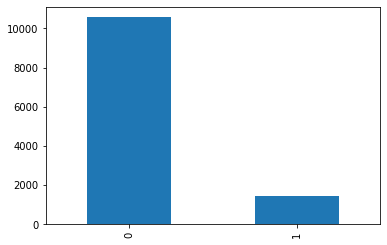

In [122]:
# Plotting users adopted vs. not adopted
_ = df.adopted.value_counts().plot(kind='bar')

In [123]:
# Split data into X and y
X = df.drop(['adopted'],axis=1)
y = df['adopted']

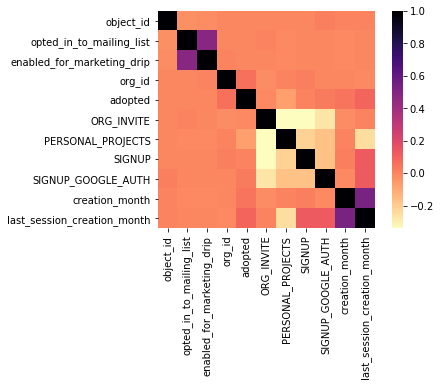

In [124]:
# Correlation matrix
_ = sns.heatmap(df.corr().round(2), square=True ,cmap='magma_r')

- Correlation matrix is showing that the last_session_creation_month correaletes with user adoption the most
- The weakest correlation with user adoption comes from personal projects

### Splitting data into Train and Test sets

In [125]:
df.adopted.value_counts()

0    10568
1     1432
Name: adopted, dtype: int64

In [126]:
# Bootstrapping postive adopted target for a more balanced dataset
from sklearn.utils import shuffle, resample
adopted = df[df['adopted']== 1]
adopted = resample(adopted, 
                  replace=True, # Sample with replacement
                  n_samples=10568, # Want to have same number of postiive reviews
                  random_state=123)

In [127]:
# Combinbing dfs back together
not_adopted = df[df['adopted'] == 0]
bs_df = pd.concat([not_adopted, adopted])

In [128]:
bs_df.adopted.value_counts()

1    10568
0    10568
Name: adopted, dtype: int64

In [129]:
# Shuffling balanced dataframe
df_shuffled = shuffle(bs_df)

In [130]:
# Importing ML Libraries
from sklearn.model_selection import train_test_split
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve

In [131]:
# Getting features and target
features = df_shuffled.drop(['object_id', 'org_id','adopted'], axis=1)
target = df_shuffled['adopted']

In [148]:
features

,opted_in_to_mailing_list,enabled_for_marketing_drip,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH,creation_month,last_session_creation_month
9769,1,1,1,0,0,0,8,1
248,0,0,0,0,0,0,3,3
8861,0,0,0,0,0,0,5,6
9231,0,0,0,0,0,1,10,10
6942,0,0,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...
10245,0,0,0,1,0,0,1,6
8301,0,0,0,0,0,1,4,5
4048,1,1,0,0,0,0,6,6
784,0,0,1,0,0,0,5,5


In [133]:
# Seperate training and testing data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=123)

#### Logistic Regression Classifier

In [134]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=20)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [136]:
#Checking to see how well the model worked

print('R-squared score: ',model.score(X_test, y_test))
print('Confusion Matrix: ')
print(confusion_matrix(y_test, y_pred))
print()
print(classification_report(y_test, y_pred))

R-squared score:  0.6487701040681173
Confusion Matrix: 
[[1252  882]
 [ 603 1491]]

              precision    recall  f1-score   support

           0       0.67      0.59      0.63      2134
           1       0.63      0.71      0.67      2094

    accuracy                           0.65      4228
   macro avg       0.65      0.65      0.65      4228
weighted avg       0.65      0.65      0.65      4228



#### Support Vector Machine

In [137]:
from sklearn.svm import LinearSVC

svc = LinearSVC(random_state=20)
svc.fit(X_train, y_train)
y_pred2 = svc.predict(X_test)

C:\Users\ZachP\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [138]:
#Checking to see how well the model worked

print('R-squared score: ',svc.score(X_test, y_test))
print('Confusion Matrix: ')
print(confusion_matrix(y_test, y_pred2))
print()
print(classification_report(y_test, y_pred2))

R-squared score:  0.663197729422895
Confusion Matrix: 
[[1194  940]
 [ 484 1610]]

              precision    recall  f1-score   support

           0       0.71      0.56      0.63      2134
           1       0.63      0.77      0.69      2094

    accuracy                           0.66      4228
   macro avg       0.67      0.66      0.66      4228
weighted avg       0.67      0.66      0.66      4228



#### Random Forest

In [139]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(max_depth=5, random_state=20)
rfc.fit(X_train, y_train)
y_pred3 = rfc.predict(X_test)

In [140]:
print('R-squared score: ',rfc.score(X_test, y_test))
print('Confusion Matrix: ')
print(confusion_matrix(y_test, y_pred3))
print()
print(classification_report(y_test, y_pred3))

R-squared score:  0.8805581835383159
Confusion Matrix: 
[[1784  350]
 [ 155 1939]]

              precision    recall  f1-score   support

           0       0.92      0.84      0.88      2134
           1       0.85      0.93      0.88      2094

    accuracy                           0.88      4228
   macro avg       0.88      0.88      0.88      4228
weighted avg       0.88      0.88      0.88      4228



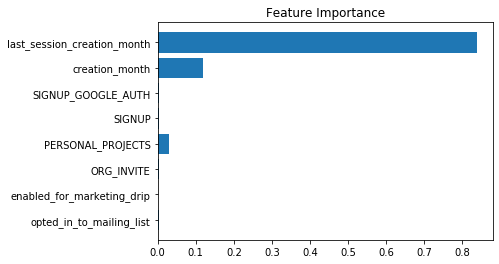

In [147]:
_ = plt.barh(features.columns, rfc.feature_importances_)
_ = plt.title('Feature Importance')

Not surprisingly, users who have created their accounts and logged in the most recently are considered adopted users. 
There will need to be further analysis done on other subsets of users to predict what behavior drives adotped users.